# Feature Preparation Notebook

This notebook curates annotations for traits and gene sets. These include:
* All the gene set annotations from *Notebook 1C*
* Network properties of the gene sets
* Heritability and prevalence estimates

**Inputs:**
* Supplemental Table 1 - Input Information (`STable1.tsv`)
* Supplemental Table 2 - NetColoc Results (`Stable2.tsv`)
* Biological properties of gene sets (`Features_bio_genesets.txt`)

* Network properties of gene sets (`Raw_network_features.txt`)

**Figures Generated:**
- SFig 2A - feature correlations

**Data generated:**
- Supplemental Table 3 - Heritability and Prevalance estimates
- Regression Features (`regression_features.txt`)
* Trait and study features (`Raw_input_features.txt`)


## Set Up

In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

### Load COLOC data

In [5]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [6]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()

In [7]:
all_pairs = coloc_df.trait_pair.values

In [8]:
best_pairs = best_df.trait_pair.values

### Load Biological Features

In [9]:
bio_df = pd.read_csv(os.path.join(datadir, 'outputs/Features_bio_genesets.txt'), sep='\t', index_col=0)
bio_df = bio_df.loc[:,[ 'sHet', 'Length', 'GO', 'n_mrna', 'mrna', 'Set'] ]
bio_df = bio_df.rename(columns={'sHet':'Constraint', 'Length':'GeneSize', 
                                'GO':'GO', 'n_mrna':'nTissues', 'mrna':'mRNA', 
                                'Set':'Set'})

### Load Study & Study Design Features

In [68]:
study_info = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t',
                        usecols=['Mapped EFO', 'Study Identifier', 'Variant Type', 'Population Sample Size', 'Gene Count',
                                'Trait Type', 'Biological Domain', 'Mapped Trait'])
study_info.columns = ['TRAIT', 'EFO', 'Study', 'Set', 'trait_type', 'Domain', 'N', 'g' ]
study_info['StudyTrait'] = study_info['Study'] + '_' + study_info['EFO']
info_df = study_info.copy()

In [69]:
coloc_feat = coloc_df.loc[:, ['EFO', 'Trait', 'Common Study', 'Rare Study', 'nCommon', 'nRare', 'nShared', 'Log2SizeOE', 
                              'trait_pair']]

In [70]:
rare_info = info_df[info_df.Set=='Rare'].loc[:, ('Study', 'N', 'g', 'EFO', "TRAIT")].drop_duplicates()
rare_info['Study'] = rare_info['Study'].astype(int)
input_df = coloc_feat.merge(rare_info, 
                           left_on=['EFO', 'Trait', 'Rare Study'], right_on=['EFO', 'TRAIT', 'Study'], how='left')

In [66]:
input_df = pd.read_csv(os.path.join(datadir, 'outputs/Raw_input_features.txt'), sep='\t')
input_df.shape

(746, 5)

### Load Network Features

In [24]:
net_df = pd.read_csv(os.path.join(datadir, 'outputs/Raw_network_features.txt'), sep='\t', index_col=0)

In [25]:
net_df.head()

,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort,n_rare,n_common,n_overlap,trait_pair
0,rare,0.333333,2,1872.250000,1.000000,0.264898,0.000000,-0.000438,1.666667,NaN,4,9,0,34662886_EFO_0000095_GCST002073_EFO_0000095
1,common,0.333333,2,420.111111,2.666667,0.309568,0.500000,0.005860,1.722222,NaN,4,9,0,34662886_EFO_0000095_GCST002073_EFO_0000095
2,overlap,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,4,9,0,34662886_EFO_0000095_GCST002073_EFO_0000095
3,rare_common,0.243590,1,866.923077,2.923077,0.289263,0.307692,0.001912,1.794872,0.272031,4,9,0,34662886_EFO_0000095_GCST002073_EFO_0000095
4,rare,0.071429,6,657.375000,0.500000,0.311598,0.000000,0.000078,2.250000,NaN,8,4,0,34375979_EFO_0000096_GCST002643_EFO_0000096


## Heritability  and Prevalence

### Heritability

In [26]:
ukb_df = pd.read_csv(os.path.join(datadir,'Reference_Data/ukb31063_h2_topline.02Oct2019.tsv.gz'), sep='\t')

In [27]:
# exclude pigmentation and bilirubin 
# (as per https://nealelab.github.io/UKBB_ldsc/confidence.html#unusually_large_standard_errors)
exclude = ['1717', '1727', '1747_1','1747_2','1747_3', '1747_4', '1747_5','1747_6', '30660_irnt', '30840_irnt']

In [28]:
ukb_df = ukb_df[(~ukb_df.phenotype.isin(exclude)) & (~ukb_df.isBadOrdinal)]

#### Trait matching

In [33]:
domain_info = info_df.loc[:, ['EFO', 'trait_type', 'Domain', 'TRAIT']].drop_duplicates()

In [34]:
ukb = model.encode(ukb_df.description.values, batch_size=32)
efo = model.encode(domain_info.TRAIT.values, batch_size=32)
cosines = cosine_similarity(ukb, efo)

In [35]:
results = []
for i in range(373):
    best = np.argmax(cosines[:, i])
    results.append((domain_info.TRAIT.values[i], ukb_df.description.values[best], cosines[best, i]))

Perform manual curation

In [36]:
pd.DataFrame(results, columns=['EFO', 'UKB', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/heritability_data_match.tsv'), sep='\t')

In [37]:
matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet1.tsv'), sep='\t', index_col=0)

In [38]:
matches = matches[matches.Keep==1]
matched_EFO = domain_info[domain_info.TRAIT.isin(matches.EFO.values)]
matches = matches.rename(columns={'EFO':'TRAIT', 'UKB':'description'})

In [39]:
h_df = ukb_df[ukb_df.description.isin(matches.description.values)]
h_df = h_df.merge(matches, on='description', how='left')
h_df = h_df.merge(matched_EFO, on=[ 'TRAIT'], how='left')
# duplicate UKB traits
h_df = h_df[~h_df.phenotype.isin(['23104_irnt', '23098_irnt'])]

In [40]:
h_df.shape

(197, 43)

### Prevalence

In [41]:
gbd_df = pd.read_csv(os.path.join(datadir, 'Reference_Data/IHME-GBD_2021_DATA-Prevalence.csv'))
gbd_df = gbd_df.groupby(['measure_id', 'measure_name', 'location_id', 'location_name', 'sex_id',
       'sex_name', 'age_id', 'age_name', 'cause_id', 'cause_name', 'metric_id',
       'metric_name']).mean().reset_index()

#### Trait matching

In [42]:
gbd_ids = list(gbd_df.cause_name.unique())

gbd = model.encode(gbd_ids, batch_size=32)
cosines2 = cosine_similarity(gbd, efo)
results2 = []
for i in range(373):
    best = np.argmax(cosines2[:, i])
    results2.append((domain_info.TRAIT.values[i], gbd_ids[best], cosines2[best, i]))

In [43]:
pd.DataFrame(results2, columns=['EFO', 'GBD', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/prevalence_data_match.tsv'), sep='\t')

In [44]:
prev_matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet2.tsv'), sep='\t', index_col=0)
prev_matches = prev_matches[prev_matches.Keep==1]

In [45]:
matched_EFO = domain_info[domain_info.TRAIT.isin(prev_matches.EFO.values)]
prev_matches = prev_matches.rename(columns={'EFO':'TRAIT', 'GBD':'cause_name'})
prev_df = gbd_df[gbd_df.cause_name.isin(prev_matches.cause_name.values)]
prev_df = prev_df.merge(prev_matches, on='cause_name', how='left')
prev_df = prev_df.merge(matched_EFO, on='TRAIT', how='left')

In [46]:
prev_df = prev_df[prev_df.metric_name=='Percent'].loc[:, ('EFO', 'val')].rename(columns={'val':'prevalence5year'})

In [ ]:
prev_df.to_csv(os.path.join(datadir, 'outputs/Trait_prevalence.txt'), sep='\t', index=False)

In [ ]:
prev_df.shape

## Supplemental Table 3

In [47]:
h2_prev = h_df.loc[:, ['EFO', 'h2_observed', ]].merge(prev_df.loc[:, ['EFO','prevalence5year']], on='EFO', how='outer')

In [48]:
h2_prev.columns = ['EFO', 'SNP-Heritability', '5 Year Prevalence']

In [ ]:
h2_prev.to_csv(os.path.join(datadir, 'outputs/STable3.tsv'), sep='\t', index=False)

## Feature Engineering

### Biological features

In [50]:
# decision = go with mean and DiffRC
def get_mean_diff_rc(bio_df,info_df, metrics=[ 'pli', 'Length', 'GO', 'mrna', 'n_mrna']):
    out_dict = {}
    for tR, tC, oe, j, nc, nr in tqdm(zip(info_df.TraitR.values, info_df.TraitC.values, info_df.log2SizeOE.values, 
                                  info_df.n_overlap.values, info_df.n_common.values, info_df.n_rare)):
        out_dict[tR+'_'+tC] = {'log2SizeOE':oe, 'n_overlap':j}
        for metric in metrics:
            vals = bio_df.loc[[tR, tC], [metric, 'Set']].set_index('Set')[metric].to_dict()
            out_dict[tR+'_'+tC][f'Mean_{metric}'] =  (nc*vals['Common'] + nr*vals['Rare'])/(nc+nr)
            out_dict[tR+'_'+tC][f'DiffRC_{metric}'] = 2*(vals['Rare']- vals['Common'])/(vals['Rare']+vals['Common'])
                                  
    out_df = pd.DataFrame(out_dict).T
    sns.clustermap(out_df.corr(method='spearman'), figsize=(3,3), cmap='vlag', center=0)
    return out_df

In [51]:
input_df['TraitR'] = input_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[0:3]))
input_df['TraitC'] = input_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[3:]))

1634it [00:05, 305.21it/s]


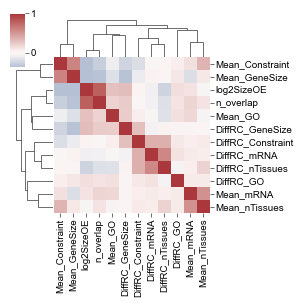

In [52]:
bio_feat = get_mean_diff_rc(bio_df, input_df, metrics= ['Constraint', 'GO', 'GeneSize', 'mRNA', 'nTissues'])

### Network Features

In [53]:
use_net = net_df.loc[~net_df.varset.isin(['subnetwork', 'overlap']), ('trait_pair', 'subnetwork_density', 'assortativity', 'varset')]
use_net = use_net.pivot(index='trait_pair', columns='varset', values=['subnetwork_density', 'assortativity']).reset_index()

In [54]:
net_features = [['subnetwork_density', 'rare'], 'subnetwork_density-common', 'assortativity-rare_common']
net_feat = use_net.loc[:, [('trait_pair', ''), ('subnetwork_density', 'rare'), ('subnetwork_density', 'common'), ('assortativity', 'rare_common')]]
net_feat.columns=['trait_pair', 'subnetwork_density_rare', 'subnetwork_density_common', 'assortativity_rare_common']
net_feat = net_feat.set_index('trait_pair')

In [55]:
net_feat.columns=['density_R', 'density_C', 'assortativity_RC']

### Trait/Study Features

In [56]:
input_feat = input_df.loc[:, ['trait_pair', 'binary', 'jaccard', 'jaccard_zero', 'n_rare', 'n_common', 'N_C', 'N_R', 'log2SizeOE']].set_index('trait_pair')
input_feat.index.name=''

## Export Features

In [57]:
all_feat = net_feat.join(input_feat)

In [58]:
all_feat = all_feat.join(bio_feat.drop(columns=['n_overlap', 'log2SizeOE']))

In [64]:
all_feat.to_csv(os.path.join(datadir, 'outputs/regression_features.txt'), sep='\t')

In [65]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_RC':'Assortativity',
    'n_common': 'Number of Genes - Common',
    'n_rare': 'Number of Genes - Rare',
    'jaccard': 'Jaccard Sim.',
    'density_R': 'Subnetwork Density - Rare',
    'density_C': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes', 
    'Mean_Constraint': 'Mean Constraint', 
    'DiffRC_Constraint':'Diff. Constraint', 
    'Mean_GeneSize':'Mean Gene Size', 
    'DiffRC_GeneSize':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mRNA': 'Mean Exp.', 
    'DiffRC_mRNA': 'Diff. Exp.', 
    'Mean_nTissues': 'Mean Exp. Tissues',
    'DiffRC_nTissues': 'Diff. Exp. Tissues'}

In [61]:
all_feat.head()

,density_R,density_C,assortativity_RC,binary,jaccard,jaccard_zero,n_rare,n_common,N_C,N_R,...,Mean_Constraint,DiffRC_Constraint,Mean_GO,DiffRC_GO,Mean_GeneSize,DiffRC_GeneSize,Mean_mRNA,DiffRC_mRNA,Mean_nTissues,DiffRC_nTissues
trait_pair,,,,,,,,,,,,,,,,,,,,,
19847924_EFO_0001645_GCST010866_EFO_0001645,0.0,0.045558,0.005521,1,0.0,1,6,99,649058.0,4764.0,...,0.045604,-1.150682,19.771429,-0.222222,111587.000000,-1.389547,13.801416,-0.415252,52.971429,-0.009479
19847924_EFO_0001645_GCST011488_EFO_0001645,0.0,0.300000,0.000446,1,0.0,1,6,5,66643.0,4764.0,...,0.012499,0.058250,17.363636,-0.171429,75381.090909,-1.478176,7.956012,0.360069,52.727273,-0.009479
19847924_EFO_0001645_GCST90132305_EFO_0001645,0.0,0.008403,-0.000512,1,0.0,1,6,35,1077578.0,4764.0,...,0.019842,-0.485055,15.146341,0.064516,156237.000000,-1.579342,8.089873,0.156914,52.073171,0.009569
19847924_EFO_0001645_GCST90446534_EFO_0001645,0.0,0.106061,0.004535,1,0.0,1,6,33,459138.0,4764.0,...,0.044084,-1.180213,21.076923,-0.315789,92777.000000,-1.335380,9.984043,-0.091197,51.230769,0.028986
19847924_EFO_0001645_GCST90449059_EFO_0001645,0.0,0.110887,0.004137,1,0.0,1,6,32,640258.0,4764.0,...,0.035141,-1.016074,22.315789,-0.379747,85553.131579,-1.289639,13.666197,-0.443203,52.500000,0.000000


In [62]:
plot_feat = all_feat.rename(columns=feature_names)

## SFig 2A - Feature Correlations

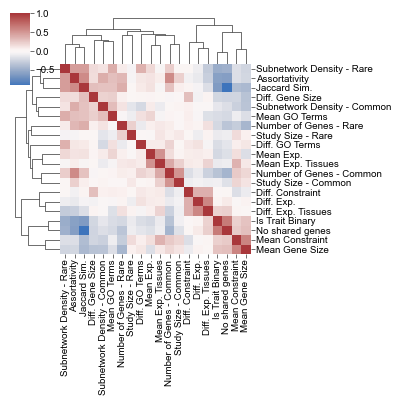

In [63]:
sns.clustermap(plot_feat.drop(columns='log2SizeOE').corr(method='spearman'), figsize=(4,4), cmap='vlag', center=0)